In [1]:
import sys
sys.path.append('..')
from olfactory_navigation.agents import QAgent

from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import cupy as cp

[Warning] milp library not available, LP solvers will be disabled.


/home/rando/anaconda3/envs/olfactory_navigation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(0)

In [4]:
from olfactory_navigation import Environment

In [5]:
data_path = "/storage/rando/data/nose_data_27_123.npy" # INSERT YOUR PATH

env = Environment(data=data_path,
                  source_position=[13, 0],
                  source_radius=2,
                  margins=[14, 62],
                  boundary_condition='no',
                  start_zone='odor_present',
                  odor_present_treshold=3e-6)

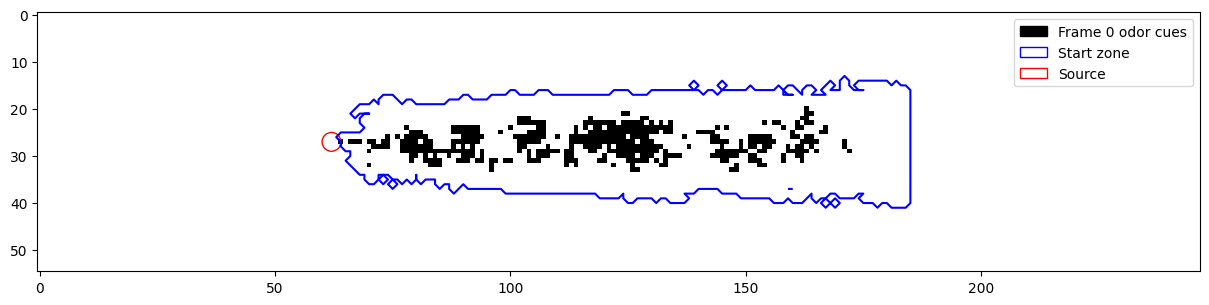

In [6]:
env.plot()

In [22]:
env.save(force=True)

Environment saved to: ./Env-55_247-edge_no-start_odor_present-source_27_62_radius2


In [92]:
memory_size = 10
time_disc = 500
horizon = 1000
num_episodes=10000#50000
delta = 500
gamma = 1.0
eps_decay = 0.0001
alpha_decay = 0.00005
eps = lambda t : 0.8 * np.exp(-eps_decay * t)  #if np.exp(-eps_decay * t)  > 0.3 else 0.3
alpha = lambda t : 0.6* np.exp(-alpha_decay * t) # if np.exp(-alpha_decay * t) > 0.0001 else 0.0001 #0.3 * np.exp(-alpha_decay * t) > 0.001 else 0.001

checkpoint_folder = "./q_agent_training/checkpoints_3"
checkpoint_frequency = 5000


ag = QAgent(env, 
            memory_size=memory_size, 
            treshold=3e-6,
            time_disc=time_disc, 
            horizon=horizon,
            num_episodes=num_episodes,
            delta=delta,
            eps_greedy= eps,
            learning_rate=alpha,
            gamma = gamma,
            seed=13141516,
            checkpoint_folder=checkpoint_folder,
            checkpoint_frequency=checkpoint_frequency
            )

In [96]:
np.random.seed(121314)
training_result = ag.train()


100%|██████████| 10000/10000 [01:19<00:00, 125.93it/s, episode=4e+4, init_pos=[23 86], init time slice=635, avg R_t=0.99, eps=0.014652511110987344, alpha=0.08120116994196762]    


In [97]:
ag.Q

array([[98.56540204,  0.        ,  0.        ,  0.        ],
       [98.08631051, 97.92929992, 97.9297855 , 97.92902731],
       [97.87791168, 98.06359912, 97.87621665, 97.87586904],
       ...,
       [98.92981431, 92.24183243, 92.77116827, 92.06265672],
       [98.73659279, 92.4400551 , 92.0096994 , 92.17540424],
       [92.150985  , 98.38454641, 92.29757677, 93.43848947]])

[0. 0.] [ 0. -1.]
[ 0. -1.] [ 0. -2.]
[ 0. -2.] [ 1. -2.]
[ 1. -2.] [ 2. -2.]
[ 2. -2.] [ 1. -2.]
[ 1. -2.] [ 1. -3.]
[ 1. -3.] [ 1. -4.]
[ 1. -4.] [ 1. -3.]
[ 1. -3.] [ 0. -3.]
[ 0. -3.] [ 0. -2.]


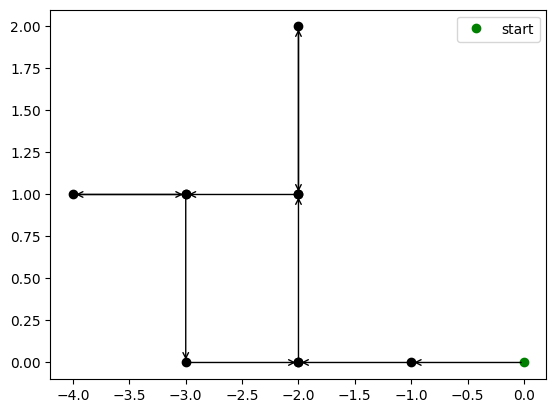

In [99]:
pos = np.array([0.0, 0.0])
fig, ax = plt.subplots()
for i in range(10):
    next_pos = pos + ag.action_set[ag.Q[i, :].argmax()]
    print(pos, next_pos)
#    print("[--] state = {}\taction = {}".format(i, ag.Q[i, :].argmax()))
    ax.plot(next_pos[1], next_pos[0], 'o', c='black')
    ax.annotate("", xy=(next_pos[1], next_pos[0]), xytext=(pos[1], pos[0]), arrowprops=dict(arrowstyle='->', color='black'))
    pos = next_pos
ax.plot(0.0, 0.0, 'o', c='green', label='start')
ax.legend()

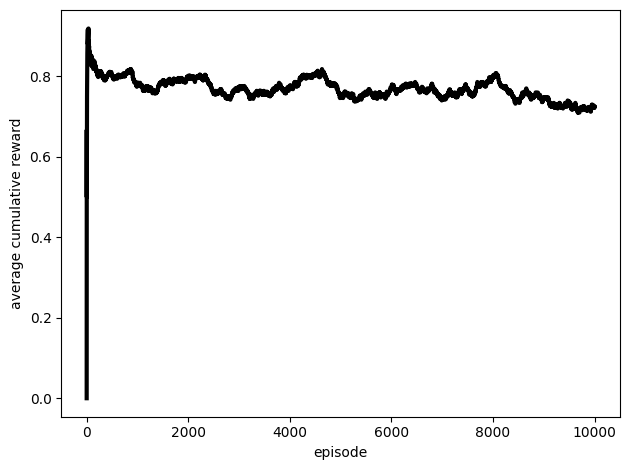

In [26]:
average_cumulative_reward = training_result['average_cumulative_reward']

fig, ax = plt.subplots()

ax.plot(range(average_cumulative_reward.shape[0]), average_cumulative_reward, '-', lw=3, c='black')

ax.set_xlabel("episode")
ax.set_ylabel("average cumulative reward")

fig.tight_layout()
fig.savefig("./training_result.pdf", bbox_inches='tight')

In [27]:
(ag.Q.argmax(axis=1) == 2).sum(), (ag.Q.argmax(axis=1) == 3).sum()

(25, 29)

In [88]:
ag.deterministic = True

In [ ]:
#ag.save("./")

In [104]:
ag.load(".")

In [111]:
from olfactory_navigation.simulation import run_test

histories = {i:None for i in [0, 100, 1000, 2000, 2400]}
for time_shift in histories.keys():
    print(f"[--] Time shift = {time_shift}")
    histories[time_shift] = run_test(n=100000, agent=ag, horizon=1000, time_shift=time_shift,  use_gpu=False)

[--] Time shift = 0


  0%|          | 0/1000 [00:00<?, ?it/s, done =0 of 100000 (0.0%)]

100%|██████████| 1000/1000 [00:03<00:00, 257.71it/s, done =94217 of 100000 (94.2%)]


Simulations done in 3.882s:
Simulations reached goal: 94217/100000 (5783 failures) (94.22%)
	- Average step count: 157.02284 (Successfull only: 105.28125497521678)
	- Extra steps: 86.09197 (Successful only: 34.14721334790961)
	- Average discounted rewards (ADR): 0.385 (Successfull only: 0.409) (discount: 0.99)
	- Tmin/T: 0.693 (Successful only: 0.732)
[--] Time shift = 100


100%|██████████| 1000/1000 [00:03<00:00, 251.91it/s, done =93345 of 100000 (93.3%)]


Simulations done in 3.971s:
Simulations reached goal: 93345/100000 (6655 failures) (93.34%)
	- Average step count: 164.58255 (Successfull only: 105.0217472815898)
	- Extra steps: 93.63473 (Successful only: 34.16570785794633)
	- Average discounted rewards (ADR): 0.383 (Successfull only: 0.410) (discount: 0.99)
	- Tmin/T: 0.692 (Successful only: 0.736)
[--] Time shift = 1000


100%|██████████| 1000/1000 [00:04<00:00, 248.66it/s, done =92516 of 100000 (92.5%)]


Simulations done in 4.023s:
Simulations reached goal: 92516/100000 (7484 failures) (92.52%)
	- Average step count: 169.26826 (Successfull only: 102.06695058152103)
	- Extra steps: 98.1575 (Successful only: 30.371049332007438)
	- Average discounted rewards (ADR): 0.374 (Successfull only: 0.405) (discount: 0.99)
	- Tmin/T: 0.686 (Successful only: 0.736)
[--] Time shift = 2000


 60%|█████▉    | 597/1000 [00:03<00:02, 175.21it/s, done =89603 of 100000 (89.6%)]


Simulations done in 3.408s:
Simulations reached goal: 89603/100000 (10397 failures) (89.60%)
	- Average step count: 151.92266 (Successfull only: 100.16249455933395)
	- Extra steps: 81.05368 (Successful only: 30.424226867403995)
	- Average discounted rewards (ADR): 0.377 (Successfull only: 0.420) (discount: 0.99)
	- Tmin/T: 0.679 (Successful only: 0.743)
[--] Time shift = 2400


 20%|█▉        | 197/1000 [00:02<00:09, 80.69it/s, done =81550 of 100000 (81.5%)] 


Simulations done in 2.442s:
Simulations reached goal: 81655/100000 (18345 failures) (81.66%)
	- Average step count: 110.59683 (Successfull only: 90.96041883534383)
	- Extra steps: 39.50424 (Successful only: 25.250358214438798)
	- Average discounted rewards (ADR): 0.387 (Successfull only: 0.443) (discount: 0.99)
	- Tmin/T: 0.704 (Successful only: 0.755)


In [9]:
hist.save()

Simulations saved to: ./Simulations-s_55_247-n_10000-horizon_198-04182024_110753.csv


In [23]:
hist.plot(14)

In [ ]:
ag.Q[0, :]

array([133.77937272, 133.71913402, 133.71757199, 133.72083726])